# Skorch introduction

(borrowed from skorch documentation)

*`skorch`* is designed to maximize interoperability between `sklearn` and `pytorch`. The aim is to keep 99% of the flexibility of `pytorch` while being able to leverage most features of `sklearn`. Below, we show the basic usage of `skorch` and how it can be combined with `sklearn`.


In [1]:
# ! [ ! -z "$COLAB_GPU" ] && pip install skorch

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0);

## Training a classifier and making predictions

### A toy binary classification task

We load a toy classification task from `sklearn`.

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.manifold import locally_linear_embedding
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
X, y = make_classification(2000, 20, n_informative=10, n_classes=2, random_state=0)
X = X.astype(np.float32)

In [5]:
X.shape, y.shape, y.mean()

((2000, 20), (2000,), 0.4995)

(2000, 2)

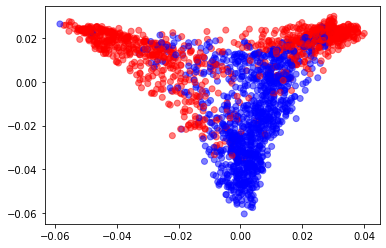

In [6]:
X_reduced, err = locally_linear_embedding(X, n_neighbors=5, n_components=2)
# PCA would be a better choice here, but LLE is more fun
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='bwr', alpha=0.5);
X_reduced.shape

### Definition of the `pytorch` classification `module`

We define a vanilla neural network with two hidden layers. The output layer should have 2 output units since there are two classes. In addition, it should have a softmax nonlinearity, because later, when calling `predict_proba`, the output from the `forward` call will be used.

In [7]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

### Defining and training the neural net classifier

We use `NeuralNetClassifier` because we're dealing with a classifcation task. The first argument should be the `pytorch module`. As additional arguments, we pass the number of epochs and the learning rate (`lr`), but those are optional.

*Note*: To use the CUDA backend, pass `device='cuda'` as an additional argument.

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device='cuda',  # comment this to train with CPU
)

As in `sklearn`, we call `fit` passing the input data `X` and the targets `y`. By default, `NeuralNetClassifier` makes a `StratifiedKFold` split on the data (80/20) to track the validation loss. This is shown, as well as the train loss and the accuracy on the validation set.

In [ ]:
net.fit(X, y)

Also, as in `sklearn`, you may call `predict` or `predict_proba` on the fitted model.

### Making predictions, classification

In [ ]:
y_pred = net.predict(X[:5])
y_pred

In [ ]:
y_proba = net.predict_proba(X[:5])
y_proba

## Usage with sklearn `GridSearchCV`

### Special prefixes

The `NeuralNet` class allows to directly access parameters of the `pytorch module` by using the `module__` prefix. So e.g. if you defined the `module` to have a `num_units` parameter, you can set it via the `module__num_units` argument. This is exactly the same logic that allows to access estimator parameters in `sklearn Pipeline`s and `FeatureUnion`s.

This feature is useful in several ways. For one, it allows to set those parameters in the model definition. Furthermore, it allows you to set parameters in an `sklearn GridSearchCV` as shown below.

In addition to the parameters prefixed by `module__`, you may access a couple of other attributes, such as those of the optimizer by using the `optimizer__` prefix (again, see below). All those special prefixes are stored in the `prefixes_` attribute:

In [ ]:
print(', '.join(net.prefixes_))

### Performing a grid search

Below we show how to perform a grid search over the learning rate (`lr`), the module's number of hidden units (`module__num_units`), the module's dropout rate (`module__dropout`), and whether the SGD optimizer should use Nesterov momentum or not (`optimizer__nesterov`).

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    verbose=0,
    optimizer__momentum=0.9,
)

In [ ]:
params = {
    'lr': [0.05, 0.1],
    'module__num_units': range(10,50), # range from 10 to 50
    'module__dropout': range(0.1, 0.3), # range from 0.1 to 0.3
    'optimizer__nesterov': [False, True],
}


In [ ]:
params = {
    'lr': [0.05, 0.1],
    'module__num_units': np.arange(10, 50, 10), # range from 10 to 50
    'module__dropout': np.linspace(0.1, 0.3, 3), # range from 0.1 to 0.3
    'optimizer__nesterov': [False, True],
}


In [ ]:
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', 
                  verbose=1, n_jobs=2)

In [ ]:
gs.fit(X, y);

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(gs.cv_results_)